In [1]:
# Import dependencies
from utils.features import *
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras import metrics
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [2]:
# Import Aus open csv with model features
df = pd.read_csv('data/aus_open_features.csv')

df = df.dropna()

# Calculate column for difference in rank between the players
df['diff_rank'] = df['player_1_rank'] - df['player_2_rank']

In [3]:
# List with the features we want from our df for X
df_features_list = [
 'diff_rank',
 'diff_match_win_percent',
 'diff_games_win_percent',
 'diff_5_sets_match_win_percent',
 'diff_close_sets_percent',
 'diff_match_win_percent_hard',
 'diff_games_win_percent_hard',
 'diff_5_sets_match_win_percent_hard',
 'diff_close_sets_percent_hard',
 'diff_match_win_percent_60',
 'diff_games_win_percent_60',
 'diff_5_sets_match_win_percent_60',
 'diff_close_sets_percent_60',
 'diff_match_win_percent_hard_100',
 'diff_games_win_percent_hard_100',
 'diff_5_sets_match_win_percent_hard_100',
 'diff_close_sets_percent_hard_100',
 'diff_match_win_percent_h2h',
 'diff_games_win_percent_h2h',
 'diff_match_win_percent_hard_h2h',
 'diff_games_win_percent_hard_h2h']

In [4]:
# Adjust test_size to 0.20 as online guides suggest it is best - don't need to preprocess - this is already done
X = df[df_features_list]
y = df.result

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [5]:
# Create model and add layers - note that sigmoid is the output layer as it is best at handling probabilities between 0 and 1
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(len(X.columns),)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [6]:
# Compile and fit the model
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,521
Trainable params: 3,521
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Adding Keras Callbacks to the model

# Early stopping monitoring value loss is added to try to ensure the model doesn't overfit - will stop after it doesn't improve after 500 iterations
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=500)

# Saves model
model_checkpoint = ModelCheckpoint('ml-model-and-predictions/model.h5', monitor='val_loss', mode='min', verbose=2, save_best_only=True)

# CSV logger to save the results of the training into a CSV file
csv_log = CSVLogger("ml-model-and-predictions/training-data.csv")

# Fit the model - verbose is 0 as recording info in csv log anyway - and only best model is being saved
history = model.fit(X_train, y_train, 
            epochs=1000, verbose=0, batch_size=128, 
            validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint, csv_log]) 

# Load the saved model
saved_model = load_model('ml-model-and-predictions/model.h5')


Epoch 00001: val_loss improved from inf to 0.57612, saving model to ml-model\model.h5

Epoch 00002: val_loss did not improve from 0.57612

Epoch 00003: val_loss did not improve from 0.57612

Epoch 00004: val_loss did not improve from 0.57612

Epoch 00005: val_loss did not improve from 0.57612

Epoch 00006: val_loss improved from 0.57612 to 0.53070, saving model to ml-model\model.h5

Epoch 00007: val_loss improved from 0.53070 to 0.52568, saving model to ml-model\model.h5

Epoch 00008: val_loss improved from 0.52568 to 0.52457, saving model to ml-model\model.h5

Epoch 00009: val_loss did not improve from 0.52457

Epoch 00010: val_loss improved from 0.52457 to 0.50978, saving model to ml-model\model.h5

Epoch 00011: val_loss did not improve from 0.50978

Epoch 00012: val_loss improved from 0.50978 to 0.49971, saving model to ml-model\model.h5

Epoch 00013: val_loss improved from 0.49971 to 0.49920, saving model to ml-model\model.h5

Epoch 00014: val_loss improved from 0.49920 to 0.49528

In [9]:
# Accuracy of the best model
training_loss, training_accuracy = saved_model.evaluate(X_train, y_train, verbose=2)
test_loss, test_accuracy = saved_model.evaluate(X_test, y_test, verbose=2)

print('Training Loss: %.3f, Training Accuracy: %.3f, Test Loss: %.3f, Test Accuracy: %.3f' % (training_loss, training_accuracy, test_loss, test_accuracy))



34/34 - 0s - loss: 0.5085 - accuracy: 0.7597
9/9 - 0s - loss: 0.4832 - accuracy: 0.7857
Training Loss: 0.508, Training Accuracy: 0.760, Test Loss: 0.483, Test Accuracy: 0.786


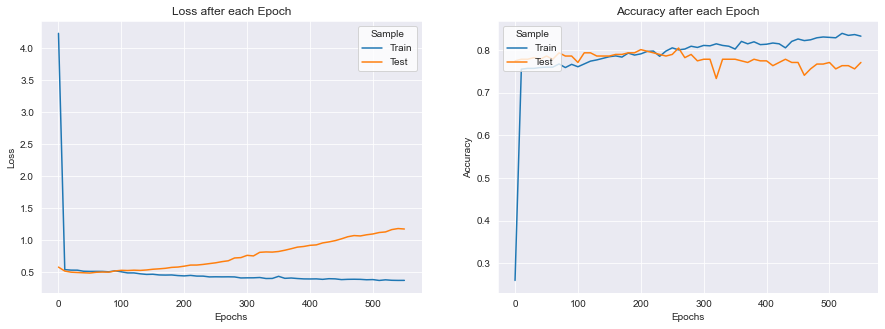

In [11]:
# Graph train/test loss and accuracy
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Loss after each Epoch')
plt.plot(history.epoch[::10], history.history['loss'][::10], label='Train')
plt.plot(history.epoch[::10], history.history['val_loss'][::10], label='Test')
plt.legend(['Train', 'Test'],loc='upper right', title='Sample', facecolor='white',fancybox=True)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.title('Accuracy after each Epoch')
plt.plot(history.epoch[::10], history.history['accuracy'][::10], label='Train')
plt.plot(history.epoch[::10], history.history['val_accuracy'][::10], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left', title='Sample', facecolor='white', fancybox=True)


plt.savefig('data/loss_acc.jpg', quality=100)

In [12]:
# Test data classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, saved_model.predict_classes(X_test)))
print(confusion_matrix(y_test, saved_model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       203
           1       0.75      0.14      0.24        63

    accuracy                           0.79       266
   macro avg       0.77      0.56      0.56       266
weighted avg       0.78      0.79      0.72       266

[[200   3]
 [ 54   9]]


C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if

In [13]:
# Trained data classification report and confusion matrix
print(classification_report(y_train, saved_model.predict_classes(X_train)))
print(confusion_matrix(y_train, saved_model.predict_classes(X_train)))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       792
           1       0.62      0.14      0.22       269

    accuracy                           0.76      1061
   macro avg       0.69      0.55      0.54      1061
weighted avg       0.73      0.76      0.70      1061

[[769  23]
 [232  37]]


C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if

In [14]:
# Read in the 2021 Australian Open data

df_2021 = pd.read_csv('data/ausopen2021.csv')
df_raw = pd.read_csv('data/combined_data.csv', low_memory=False)

df_2021['Date'] = '2021/02/17'
df_2021['Surface'] = 'Hard'
df_2021['diff_rank'] = df_2021['player_1_rank'] - df_2021['player_2_rank']

In [15]:
df_2021 = add_features(df_2021, df_raw)

Loading Player Career Stats on All Surfaces
Loading Player Career Stats on Hard Courts
Loading Player Career Stats on All Surfaces in the Last 60 Weeks
Loading Player Career Stats on Hard Court in the last 100 Weeks
Loading Player H2H Career Stats on All Surfaces
Loading Player H2H Career Stats On Hard Court
Loading variables for difference in player stats


In [17]:
# Model Predictions (0 means player_1 will win)
features_qtr = df_2021[df_features_list]

df_2021['prediction'] = saved_model.predict_classes(features_qtr)
df_2021['probability'] = 1 - np.abs(df_2021.prediction - saved_model.predict_proba(features_qtr).flatten())

aus_prediction = df_2021[['Round', 'player_1', 'player_2', 'prediction', 'probability']]

C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [18]:
aus_prediction.to_csv("ml-model-and-predictions/predictions.csv", index=False)